Measure delay for phase vs. frequency calibration.

In [1]:
import sys
sys.path.append('../../qick/qick_lib/')
sys.path.append('../soft/')
import Scan
from mkids import *
import matplotlib.pyplot as plt


In [2]:
# After running demo_00_init.ipynb we decide which bitfile we'd like to use
bitfile = "mkids_2x2_kidsim_v2"
scan = Scan.Scan(bitfile)

In [3]:
print(scan.nominalDelay)

-8.51


In [4]:
fMixerSimu = 512
fMixerKids = scan.fNyquist/2

In [5]:
# Initialize simulation chain with no resonance
simu = scan.simuChain
simu.analysis.qout(3)
simu.synthesis.qout(3)
simu.alloff()
simu.set_mixer_frequency(fMixerSimu)


In [6]:
# Initialize the kids chain
kids = scan.kidsChain
kids.analysis.qout(2)
kids.synthesis.qout(2)
kids.set_mixer_frequency(fMixerKids)

  0%|          | 0/50 [00:00<?, ?it/s]

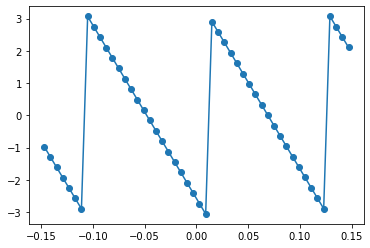

In [11]:
def scanOneOutCh(outCh, df=None, N=50, doProgress=False, fMixer=700, doApplyDelay=True):
    scan.set_mixer(fMixer)
    kids = scan.kidsChain
    qFMixer = scan.get_mixer()
    pfbFs = kids.synthesis.dict['chain']['fs']
    fMinimum = qFMixer-pfbFs/2
    fMaximum = qFMixer+pfbFs/2

    fTone = scan.outCh2Freq(outCh)
    if df is None:
        df = kids.synthesis.fc_ch
    fMin = np.maximum(fMinimum, fTone-df/2)
    fMax = np.minimum(fMaximum, fTone+df/2)
    df = fMax-fMin
    fc = (fMin+fMax)/2
    freqs = np.array([fc])
    fis = np.zeros(1)
    gs = 0.9*np.ones(1)
    kids.set_tones(freqs, fis, gs)
    fOffsets = kids.get_sweep_offsets(df, N)
    xs = scan.sweep_tones(freqs, fis, gs, None, df, N, mean=True, doProgress=doProgress, doApplyDelay=doApplyDelay)
    return xs, freqs, fOffsets
xs, freqs, fOffsets = scanOneOutCh(30, df=0.3, N=50, doProgress=True, fMixer=fMixerKids, doApplyDelay=False)
plt.plot(fOffsets, np.angle(xs), '-o')

  0%|          | 0/50 [00:00<?, ?it/s]

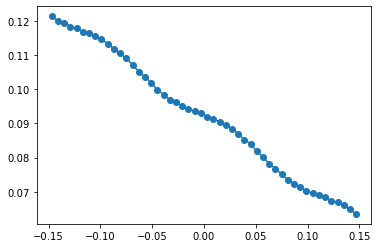

In [ ]:
xs, freqs, fOffsets = scanOneOutCh(30, df=0.3, N=50, doProgress=True, fMixer=fMixerKids, doApplyDelay=True)
plt.plot(fOffsets, np.angle(xs), '-o')

In [ ]:
raise Exception()

In [ ]:
delays = np.zeros(scan.nOutCh)
phi0s = np.zeros(scan.nOutCh)
amps = np.zeros(scan.nOutCh)
freqs = np.zeros(scan.nOutCh)
allXs = []
df = kids.synthesis.fc_ch
N = 500
for i in range(scan.nOutCh):
    delay,xs,fOffsets,f0,phi0 = getDelayForOutCh(i, df, N, fMixer=fMixerKids)
    delays[i] = delay
    phi0s[i] = phi0
    amps[i] = np.mean(np.abs(xs))
    freqs[i] = f0
    allXs.append(xs)
    print(i,f0,delay,amps[i])

In [ ]:
plt.plot(freqs, amps, '.')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude [ADUs]")
__ = plt.title("fMixer = %f MHz"%fMixerKids)

In [ ]:
plt.plot(freqs, delays, '.')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Delay [$\mu$sec]")
__ = plt.title("fMixer = %f MHz"%fMixerKids)

In [ ]:
outCh = 10
fCenter = scan.outCh2Freq(outCh)
print(fCenter)

fResonance = fCenter + 0.123
simu.alloff()
simu.enable(fResonance)
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=1.7
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)

In [ ]:
delayMean = delays.mean()
print(delayMean)
xsd = applyDelay(freqs, fOffsets, xs, delayMean)

In [ ]:
plt.plot(fOffsets, np.abs(xsd), '.')
plt.xlabel("Frequency - %f [MHz]"%freqs[0])
plt.ylabel("Amplitude [ADUs]")
plt.axvline(fResonance-freqs[0], c='r')

In [ ]:
plt.plot(fOffsets, np.angle(xsd), '.')
plt.xlabel("Frequency - %f [MHz]"%freqs[0])
plt.ylabel("Phase [Rad]")
plt.axvline(fResonance-freqs[0], c='r')

In [ ]:
plt.plot(np.real(xsd),np.imag(xsd),'.')
ind = np.searchsorted(fOffsets,fResonance-freqs[0])
plt.plot(np.real(xsd[ind]), np.imag(xsd[ind]), 'ro')
plt.gca().set_aspect('equal')
plt.xlabel("I [ADUs]")
plt.ylabel("Q [ADUs]")

In [ ]:
simu.alloff()
f0 = scan.outCh2Freq(outCh)
fc = kids.synthesis.fc_ch
print("fc =",fc)
fCenter = f0
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=fc
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)
xsd = applyDelay(freqs, fOffsets, xs, delayMean)
plt.plot(fOffsets, np.angle(xsd))
plt.title("outCh = %d"%outCh)

In [ ]:
simu.alloff()
f0 = scan.outCh2Freq(outCh+1)
fc = kids.synthesis.fc_ch
print("fc =",fc)
fCenter = f0
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=fc
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)
xsd = applyDelay(freqs, fOffsets, xs, delayMean)
plt.plot(fOffsets, np.angle(xsd))
plt.title("outCh = %d"%(outCh+1))

In [ ]:
simu.alloff()
f0 = scan.outCh2Freq(outCh)
fc = kids.synthesis.fc_ch
fCenter = f0 + fc/2
freqs = np.array([fCenter])
fis = np.zeros(1)
gs = 0.9*np.ones(1)
kids.set_tones(freqs, fis, gs)
df=1.9*fc
N=200
fOffsets = kids.get_sweep_offsets(df, N)
doProgress = True
xs = kids.sweep_tones(df, N, mean=True, doProgress=doProgress)

In [ ]:
outChs = np.unique(scan.outFreq2ch(freqs+fOffsets))

In [ ]:
xsd = applyDelay(freqs, fOffsets, xs, delayMean)

In [ ]:
plt.plot(fOffsets, np.angle(xsd))
phi = np.angle(xsd)
phi0 = np.mean(phi[fOffsets<0])
phi1 = np.mean(phi[fOffsets>0])
plt.axhline(phi0, c='r', alpha=0.3)
plt.axhline(phi1, c='r', alpha=0.3)
deltaPhi = phi1-phi0
plt.xlabel("Frequency-%.3f MHz"%freqs[0])
plt.ylabel("Phase [Rad]")
plt.title("delta phase = %.3f between outCh=%d,%d"%(deltaPhi,outChs[0],outChs[1]))